In [1]:
% matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Parameters
nruns = 12
ndiscard = 500 # discard the first this many frames
nbins = 100
frame_interval = 0.5 # nanoseconds

In [4]:
# Load trajectories
# convert to Angstroms and discard initial equilibration
runs = list()
for run_index in range(nruns):
    clones = np.load('data/run%d.npy' % run_index)
    nclones = len(clones)
    for clone_index in range(nclones):
            clones[clone_index] = clones[clone_index][ndiscard:,:] * 10 
    runs.append(clones)

In [5]:
run_index = {
    0: '1OL5-notpx2-nophos',
    1: '1OL5-notpx2-phos',
    2: '1OL5-tpx2-nophos',
    3: '1OL5-tpx2-phos',
    4: '1OL7-notpx2-nophos',
    5: '1OL7-notpx2-phos',
    6: '1OL7-tpx2-nophos',
    7: '1OL7-tpx2-phos',
    8: '5L8K-notpx2-nophos',
    9: '5L8K-notpx2-phos',
    10: '5L8K-tpx2-nophos',
    11: '5L8K-tpx2-phos',
}

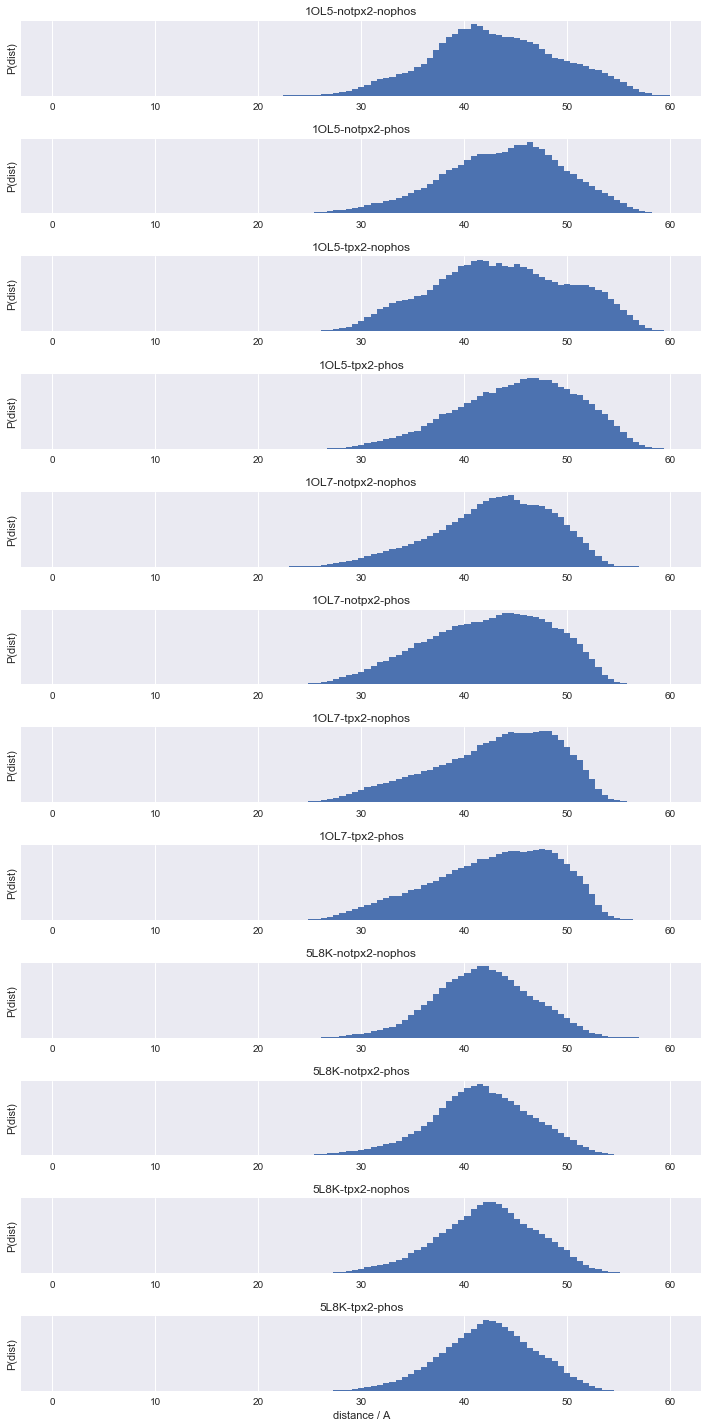

In [6]:
figure = plt.figure(figsize=[10,20])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for run in range(nruns):    
    plt.subplot(nruns,1,run+1)
    clones = runs[run]    
    plt.hist(np.concatenate([clone[:,0] for clone in clones]), bins)
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('distance / A')
    plt.ylabel('P(dist)');
    plt.title(run_index[run])

figure.tight_layout()

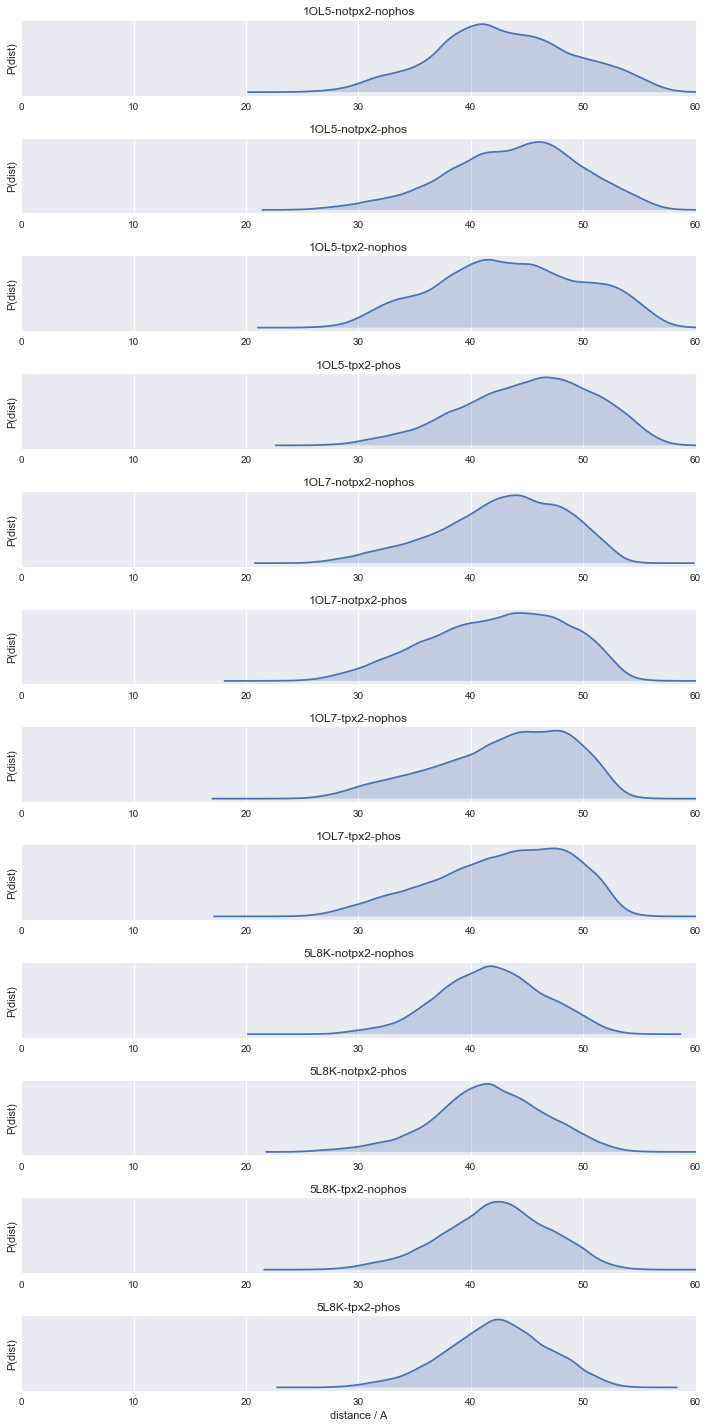

In [7]:
figure = plt.figure(figsize=[10,20])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for run in range(nruns):    
    plt.subplot(nruns,1,run+1)
    clones = runs[run]    
    sns.kdeplot(np.concatenate([clone[:,0] for clone in clones]), shade=True).set(xlim=(0, maxdist))
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('distance / A')
    plt.ylabel('P(dist)');
    plt.title(run_index[run])

figure.tight_layout()

## How much data do we have?

In [8]:
for run in range(nruns):
    clones = runs[run]    
    nframes = sum([clone.shape[0] for clone in clones])
    aggregate_time = frame_interval * nframes
    print('%64s : %8.3f ns aggregate' % (run_index[run], aggregate_time))

                                              1OL5-notpx2-nophos : 68799.500 ns aggregate
                                                1OL5-notpx2-phos : 65859.500 ns aggregate
                                                1OL5-tpx2-nophos : 54250.000 ns aggregate
                                                  1OL5-tpx2-phos : 52239.500 ns aggregate
                                              1OL7-notpx2-nophos : 75660.000 ns aggregate
                                                1OL7-notpx2-phos : 76900.000 ns aggregate
                                                1OL7-tpx2-nophos : 74949.500 ns aggregate
                                                  1OL7-tpx2-phos : 76980.000 ns aggregate
                                              5L8K-notpx2-nophos : 56430.000 ns aggregate
                                                5L8K-notpx2-phos : 52950.000 ns aggregate
                                                5L8K-tpx2-nophos : 51330.000 ns aggregate
          

## Plot only +TPX2 +phos

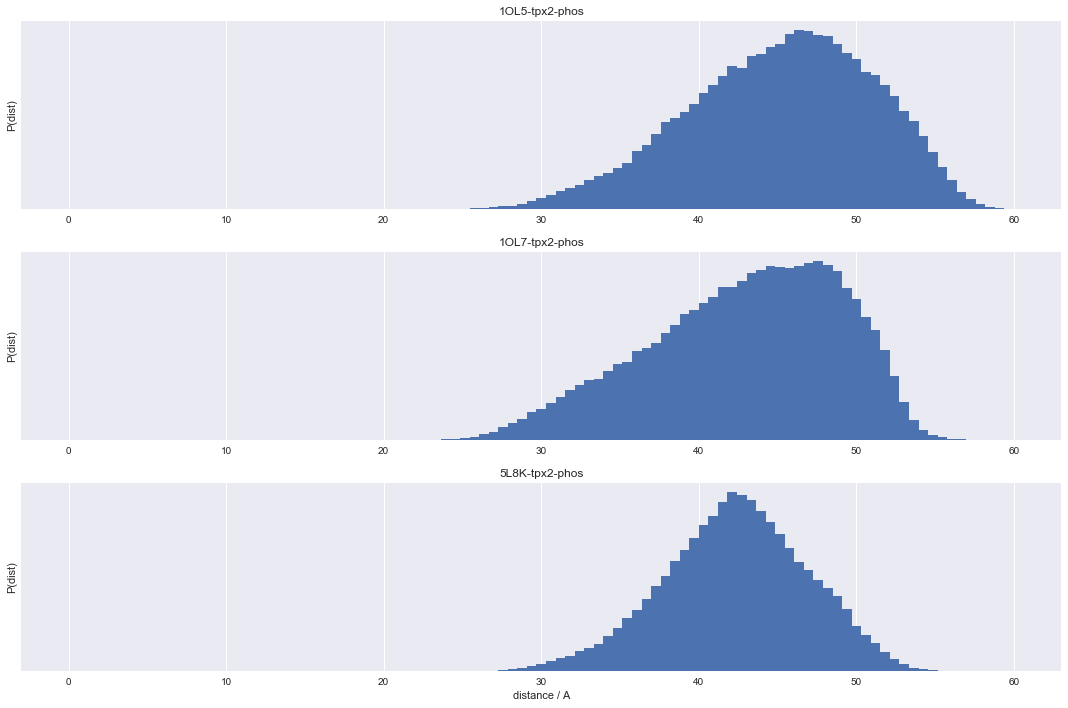

In [9]:
runs_to_plot = list()
for run in range(nruns):
    if '-tpx2-phos' in run_index[run]:
        runs_to_plot.append(run)
        
figure = plt.figure(figsize=[15,10])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for (index, run) in enumerate(runs_to_plot):    
    plt.subplot(len(runs_to_plot),1,index+1)
    clones = runs[run]    
    plt.hist(np.concatenate([clone[:,0] for clone in clones]), bins)
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('distance / A')
    plt.ylabel('P(dist)');
    plt.title(run_index[run])

figure.tight_layout()

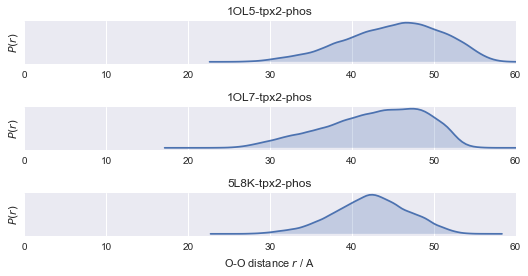

In [10]:
runs_to_plot = list()
for run in range(nruns):
    if '-tpx2-phos' in run_index[run]:
        runs_to_plot.append(run)
        
figure = plt.figure(figsize=[7.5,4])
maxdist = 60 # angstroms
bins = np.linspace(0, maxdist, nbins)
for (index, run) in enumerate(runs_to_plot):    
    plt.subplot(len(runs_to_plot),1,index+1)
    clones = runs[run]    
    sns.kdeplot(np.concatenate([clone[:,0] for clone in clones]), shade=True).set(xlim=(0, maxdist))
    plt.yticks([])
    if run != (nruns-1):
        #plt.xticks([])
        pass
    else:
        plt.xlabel('O-O distance $r$ / A')
    plt.ylabel('$P(r)$');
    plt.title(run_index[run])
    
figure.tight_layout()
figure.savefig('aurora-tpx2-phos-OO-distance.pdf')

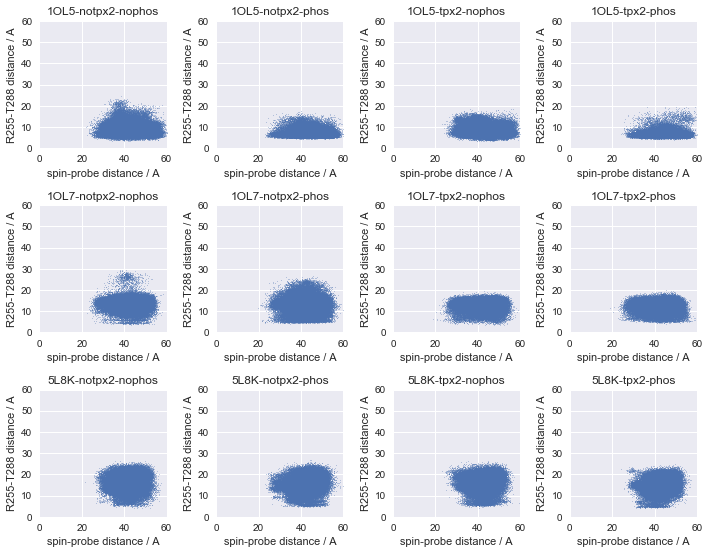

In [11]:
figure = plt.figure(figsize=[10,10])
maxdist = 60 # angstroms
for run in range(nruns):    
    plt.subplot(4,4,run+1)
    clones = runs[run]    
    OO_distance = np.concatenate([clone[:,0] for clone in clones])
    RT_distance = np.concatenate([clone[:,1] for clone in clones])
    plt.plot(OO_distance, RT_distance, '.', markersize=1)
    plt.xlabel('spin-probe distance / A')
    plt.ylabel('R255-T288 distance / A')
    plt.axis('square')
    plt.title(run_index[run])
    plt.xlim(0, maxdist)
    plt.ylim(0, maxdist)

figure.tight_layout()
figure.savefig('aurora-distance-comparison.png', dpi=300)